In [ ]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import np_utils
import treebank
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#import libraries for model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from keras.callbacks import ModelCheckpoint

***Uncomment below cell to download Penn Treebank Dataset and NLTK library***

In [ ]:
# !pip install --upgrade treebank
# !pip install nltk

In [ ]:
len(treebank.penn['train']) #characters

5101619

In [ ]:
treebank.penn['train'][0:10]

' aer bankn'

***Taking subset of the whole dataset as training data (100000 characters)***

In [ ]:
data = treebank.penn['train'][0:100000]
data = data.lower()

***Data Preprocessing***

In [ ]:
unknown_chars = {'unk','>','<','\n'}

word_tokens = word_tokenize(data)

# final sentence list where stop words are eliminated
filtered_sentence = [w for w in word_tokens if not w in unknown_chars]

print(word_tokens[10:50])
print(filtered_sentence[10:50])

['ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter', 'pierre', '<', 'unk', '>', 'n', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'n', 'mr.', '<', 'unk', '>', 'is', 'chairman', 'of', '<', 'unk']
['ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter', 'pierre', 'n', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'n', 'mr.', 'is', 'chairman', 'of', 'n.v.', 'the', 'dutch', 'publishing', 'group', 'rudolph', 'n', 'years']


In [ ]:
data_f = " "
data_final = data_f.join(filtered_sentence) #creating final data from list
chars = sorted(list(set(data_final)))

# creating dictionary of letters mapped to integers
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [ ]:
n_chars = len(data_final)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  92090
Total Vocab:  40


***Creating input features of length `seq_length` and single output feature***

In [ ]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 30
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = data_final[i:i + seq_length]
    seq_out = data_final[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  92060


In [ ]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalization
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

***Define single layer LSTM model, with dropout=20% and optimizer="adam"***

In [ ]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [ ]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
history_single = model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)

Epoch 1/20
720/720 [==============================] - 71s 96ms/step - loss: 2.9489 - accuracy: 0.1680

Epoch 00001: loss improved from inf to 2.88674, saving model to weights-improvement-01-2.8867.hdf5
Epoch 2/20
720/720 [==============================] - 67s 94ms/step - loss: 2.7900 - accuracy: 0.2056

Epoch 00002: loss improved from 2.88674 to 2.77324, saving model to weights-improvement-02-2.7732.hdf5
Epoch 3/20
720/720 [==============================] - 66s 92ms/step - loss: 2.7279 - accuracy: 0.2230

Epoch 00003: loss improved from 2.77324 to 2.71364, saving model to weights-improvement-03-2.7136.hdf5
Epoch 4/20
720/720 [==============================] - 67s 92ms/step - loss: 2.6796 - accuracy: 0.2308

Epoch 00004: loss improved from 2.71364 to 2.67145, saving model to weights-improvement-04-2.6714.hdf5
Epoch 5/20
720/720 [==============================] - 66s 91ms/step - loss: 2.6419 - accuracy: 0.2383

Epoch 00005: loss improved from 2.67145 to 2.63724, saving model to weights-i

In [ ]:
def plot_loss_vs_epochs(fitted, num_epochs, modelname):
    accuracy = fitted.history['accuracy']
    epochs = range(1,num_epochs+1)
    plt.plot(epochs, accuracy, 'g', label='Training loss')
    plt.title('Accuracy vs Epochs of ' + modelname)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


***Plotting accuracy vs number of epochs of Single Layer LSTM model***

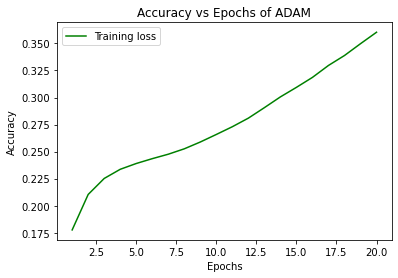

In [ ]:
plot_loss_vs_epochs(history_single, 20, "ADAM")

In [ ]:
# load the network weights
filename = "weights-improvement-20-2.1606.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [ ]:
# dictionary for reverse mapping from int to char
int_to_char = dict((i, c) for i, c in enumerate(chars))

***Testing data with a random sequence of data, and predicting sequence of length 200 characters.***

In [ ]:
# pick a random seed
import sys
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

# generate characters
for i in range(200):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
"  returned to greenville two da "
nl to tee soete oe the paseon las seeered the company said the pasion the came th the tas an the pesion as the paseon ln the company said the pasion the came th the tas an the pesion as the paseon ln 
Done.


***Define multi-layer LSTM model, with dropout=20% and optimizer="adam"***

In [ ]:
# define the multilayer LSTM model
model_multi = Sequential()
model_multi.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
model_multi.add(Dropout(0.2))
model_multi.add(LSTM(256))
model_multi.add(Dropout(0.2))
model_multi.add(Dense(y.shape[1], activation='softmax'))
model_multi.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [ ]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
history_multi = model_multi.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)

Epoch 1/20
720/720 [==============================] - 192s 261ms/step - loss: 2.9265 - accuracy: 0.1719

Epoch 00001: loss improved from inf to 2.85404, saving model to weights-improvement-01-2.8540.hdf5
Epoch 2/20
720/720 [==============================] - 173s 240ms/step - loss: 2.6868 - accuracy: 0.2269

Epoch 00002: loss improved from 2.85404 to 2.65637, saving model to weights-improvement-02-2.6564.hdf5
Epoch 3/20
720/720 [==============================] - 172s 239ms/step - loss: 2.5679 - accuracy: 0.2482

Epoch 00003: loss improved from 2.65637 to 2.55488, saving model to weights-improvement-03-2.5549.hdf5
Epoch 4/20
720/720 [==============================] - 173s 240ms/step - loss: 2.4784 - accuracy: 0.2702

Epoch 00004: loss improved from 2.55488 to 2.45425, saving model to weights-improvement-04-2.4542.hdf5
Epoch 5/20
720/720 [==============================] - 172s 239ms/step - loss: 2.3763 - accuracy: 0.2992

Epoch 00005: loss improved from 2.45425 to 2.35162, saving model to

***OBSERVATION:***
> 
Accuracy of Single Layer LSTM : 36.09%
> 
Accuracy of Multi-Layer LSTM : 52.04%
> 
We observe that Multi-Layer LSTM performs relatively better than Single Layer LSTM

In [ ]:
# load the network weights
filename = "weights-improvement-20-1.6127.hdf5"
model_multi.load_weights(filename)
model_multi.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [ ]:
# dictionary for reverse mapping from int to char
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [ ]:
# pick a random seed
import sys
# start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

# generate characters
for i in range(200):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
"  returned to greenville two danl "
 to tee rresein the mas po peeind the compiryeo oa desertie the compery said the pasion the came th the tas an the pesion th the case th the tas an the pesion th the case th the tas an the pesion th t
Done.


***Plotting accuracy vs number of epochs of Multi-Layer LSTM model***

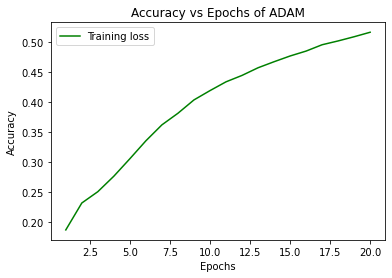

In [ ]:
plot_loss_vs_epochs(history_multi, 20, "ADAM")